In [338]:
import os
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from PIL import Image
import numpy as np
import datasets

# Define paths
image_folder = "./LhasaGanjur/Test_Images"   #download from aws 
hf_dataset_name = "ta4tsering/Lhasa_kanjur_transcription_datasets" 

# Load Hugging Face dataset
hf_dataset = datasets.load_dataset(hf_dataset_name, split="test")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")
model = TFAutoModel.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")

In [342]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("L")  # Convert to black and white
    image = np.array(image) / 255.0  # Normalize
    return image

In [346]:
def transcription_to_vector(transcription):
    tokens = tokenizer(transcription, return_tensors="tf", padding="max_length", max_length=512, truncation=True)
    inputs = {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }
    outputs = model(**inputs)
    vector = outputs.pooler_output  # Extract the pooled output as the vector representation
    return vector

In [360]:
from tqdm import tqdm

def create_dataset(image_folder, hf_dataset):
    # Filter HF dataset to include only transcriptions corresponding to images on your computer
    image_names = [filename.split(".")[0] for filename in os.listdir(image_folder) if not filename.startswith(".")]
    hf_subset = [data for data in hf_dataset if data["filename"].split(".")[0] in image_names]
    
    # Load images and preprocess them
    images = []
    for filename in tqdm(os.listdir(image_folder), desc="Loading images", unit="image"):
        if not filename.startswith("."):  # Exclude hidden files like .DS_Store
            image_path = os.path.join(image_folder, filename)
            image = preprocess_image(image_path)
            images.append(image)
    
    # Load and tokenize transcriptions
    transcriptions = [data["label"] for data in hf_subset]
    vectors = [transcription_to_vector(transcription) for transcription in tqdm(transcriptions, desc="Processing transcriptions", unit="transcription")]
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, vectors))
    return dataset

dataset = create_dataset(image_folder, hf_dataset)


Loading images: 100%|█████████| 4000/4000 [00:02<00:00, 1932.27image/s]
Processing transcriptions: 100%|█| 3999/3999 [12:19<00:00,  5.41transcr


In [476]:
# Iterate over the dataset and check the shape of the elements
for image, vector in dataset.take(1):  # Take one batch from the dataset
    print("Image shape:", image.shape)
    print("Transcription vector shape:", vector.shape)


Image shape: (70, 1400)
Transcription vector shape: (1, 768)


2024-06-13 17:09:26.492952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


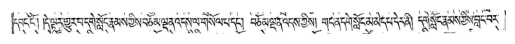

2024-06-13 17:09:28.254386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [478]:
import matplotlib.pyplot as plt

# Take one image from the dataset
for image, _ in dataset.take(1):
    # Plot the image
    plt.imshow(image.numpy(), cmap="gray")
    plt.axis("off")
    plt.show()


In [484]:
# Apply batching, caching, and prefetching to the dataset

tf_dataset=dataset
tf_dataset = tf_dataset.cache()  # Cache the dataset elements in memory
tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch data for optimal performance

In [486]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the generator model
def build_generator(vector_dim, noise_dim, img_shape):
    input_vector = layers.Input(shape=(vector_dim,))
    input_noise = layers.Input(shape=(noise_dim,))
    
    # Concatenate vector and noise inputs
    x = layers.Concatenate()([input_vector, input_noise])
    
    # Dense layer
    x = layers.Dense(128, activation='relu')(x)
    
    # Output layer
    x = layers.Dense(img_shape[0] * img_shape[1], activation='tanh')(x)
    output_img = layers.Reshape(img_shape)(x)
    
    return Model(inputs=[input_vector, input_noise], outputs=output_img)

# Define the discriminator model
def build_discriminator(vector_dim, img_shape):
    input_vector = layers.Input(shape=(vector_dim,))
    input_img = layers.Input(shape=img_shape)
    
    # Flatten the image
    flat_img = layers.Flatten()(input_img)
    
    # Concatenate vector and flattened image inputs
    x = layers.Concatenate()([input_vector, flat_img])
    
    # Dense layer
    x = layers.Dense(128, activation='relu')(x)
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=[input_vector, input_img], outputs=output)

# Define the dimensions
vector_dim = 768  # Dimensionality of the transcription vectors
noise_dim = 100  # Dimensionality of the noise input
img_shape = (70, 1400)  # Shape of the generated image

# Build the generator and discriminator models
generator = build_generator(vector_dim, noise_dim, img_shape)
discriminator = build_discriminator(vector_dim, img_shape)

# Print model summaries
print("Generator summary:")
generator.summary()
print("\nDiscriminator summary:")
discriminator.summary()


Generator summary:


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_54      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 868)       │          0 │ input_layer_53[0… │
│ (Concatenate)       │                   │            │ input_layer_54[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 128)       │    111,232 │ concatenate_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 98000)     │ 12,642,000 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_25          │ (None, 70, 1400)  │          0 │ dense_47[0][0]    │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,753,232 (48.65 MB)

 Trainable params: 12,753,232 (48.65 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator summary:


Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_56      │ (None, 70, 1400)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_55      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 98000)     │          0 │ input_layer_56[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 98768)     │          0 │ input_layer_55[0… │
│ (Concatenate)       │                   │            │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 128)       │ 12,642,432 │ concatenate_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 1)         │        129 │ dense_48[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,642,561 (48.23 MB)

 Trainable params: 12,642,561 (48.23 MB)

 Non-trainable params: 0 (0.00 B)

In [488]:
# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the batch size
batch_size = 32

In [518]:
# Define the training function
@tf.function
def train_step(images, vectors):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([vectors, noise], training=True)

        real_output = discriminator([vectors, images], training=True)
        fake_output = discriminator([vectors, generated_images], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [520]:
# Define the training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, vector_batch in dataset:
            train_step(image_batch, vector_batch)

        # Print progress
        print("Epoch {} completed".format(epoch + 1))

In [539]:
mydataset=tf_dataset.batch(batch_size, drop_remainder=True)

In [543]:
# Train the CGAN
train(mydataset, epochs=10)

2024-06-14 09:05:32.637277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 completed


2024-06-14 09:05:38.735670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 completed


2024-06-14 09:05:44.734304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 completed


2024-06-14 09:05:50.802149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 completed


2024-06-14 09:05:56.837457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 completed


2024-06-14 09:06:02.918571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6 completed


2024-06-14 09:06:09.038989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 completed


2024-06-14 09:06:15.091410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 completed


2024-06-14 09:06:21.129366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9 completed
Epoch 10 completed


2024-06-14 09:06:27.191704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


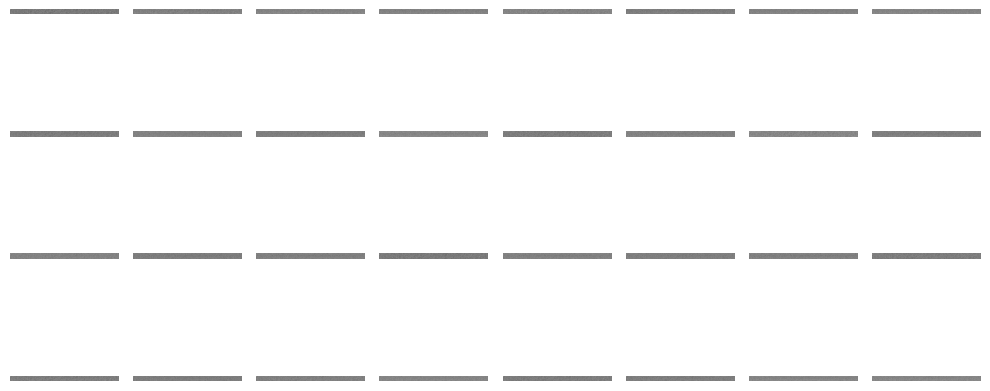

In [547]:
import matplotlib.pyplot as plt

# Generate random vectors
num_samples = batch_size  # Set num_samples to batch_size
random_vectors = tf.random.normal([num_samples, vector_dim])

# Generate images using the generator
generated_images = generator.predict([random_vectors, noise])

# Visualize the generated images
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    plt.subplot(4, 8, i + 1)  # Adjust subplot grid based on batch size
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")
model = AutoModel.from_pretrained("openpecha/tibetan_RoBERTa_S_e6")

# Define the Tibetan text
tibetan_text = "ཀྱང་ཤེས་རབ་ཀྱི་ཕ་རོལ་ཏུ་ཕྱིན་པ་མ་ཡིན། བྱང་ཆུབ་ཀྱི་ཡན་ལག་རྣམས་ཀྱི་དེ་བཞིན་ཉིད་ལས་གུད་ནའང་ཤེས་རབ་ཀྱི་ཕ་རོལ་ཏུ་ཕྱིན་པ་མེད་དོ། །བྱང་ཆུབ་ཀྱི་ཡན་ལག་རྣམས་"

# Tokenize the text
tokens = tokenizer(tibetan_text, return_tensors="pt")

# Pass the tokens through the model to get the embeddings
with tf.device('/CPU:0'):
    outputs = model(**tokens)

# Get the embeddings
embeddings = outputs.last_hidden_state

# Convert embeddings to a numpy array

# Assuming word_vector is the tensor you want to convert
# Detach the tensor from the computation graph
word_vector_detached = embeddings.detach()

# Convert the detached tensor to a NumPy array
tibetan_vector = word_vector_detached.numpy()

Some weights of RobertaModel were not initialized from the model checkpoint at openpecha/tibetan_RoBERTa_S_e6 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


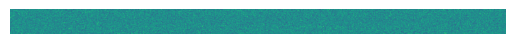

In [569]:
import tensorflow as tf
import numpy as np

# Normalize the Tibetan vector
normalized_tibetan_vector = tf.keras.utils.normalize(tf.reduce_mean(tibetan_vector, axis=1))

# Define the noise dimension
noise_dim = 100

# Generate random noise
noise = tf.random.normal([1, noise_dim])

# Concatenate the Tibetan vector and noise
input_data = [normalized_tibetan_vector, noise]

# Generate an image using the generator
generated_image = generator(input_data, training=False)

# Rescale the pixel values from [-1, 1] to [0, 1]
generated_image = (generated_image + 1) / 2

# Visualize the generated image
import matplotlib.pyplot as plt
plt.imshow(generated_image[0])
plt.axis('off')
plt.show()
